In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input,Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import os
import shutil
import random
import splitfolders
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True) #limit GPU memory

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
preprocessing_R = tf.keras.applications.resnet.preprocess_input
preprocessing_M = tf.keras.applications.mobilenet.preprocess_input
preprocessing_I = tf.keras.applications.inception_v3.preprocess_input

Num GPUs Available:  1


In [2]:
img_size=224
batch_size=32

def functional_model():
    inp=keras.Input((img_size,img_size,3), name='img_input')
    x = preprocessing_M(inp)
    x = base_model(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    predictions = Dense(2, activation= 'sigmoid')(x)
    model = Model(inputs =inp, outputs = predictions, name='cnn')
    return model

def import_model(model):
    base_model = model(weights='imagenet', include_top=False,input_shape=(img_size,img_size,3)) #, pooling='avg'
    return base_model

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.rcParams["figure.figsize"] = (10,10)



In [3]:
'''immagini con background originale'''
train_dir = "../05_Data/Tomato/train"
valid_dir = "../05_Data/Tomato/val"
test_dir = "../05_Data/Tomato/test"

'''choose the 'base model': ResNet50, MobileNet, InceptionV3'''
base_model=import_model(MobileNet)
'''early stopping'''
min_delta=0.001
mode='max'
patience = 10
'''model.compile parameters'''
lr=0.0001
loss='categorical_crossentropy'
metrics=['accuracy']
filepath=r'C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\dati'
'''model.fit parameters'''
epochs=30
verbose=2
'''Let's visualize the model for transfer learning'''
model=functional_model()
base_model.trainable = False
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                               

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical', #'int' for sparse_categorical_cross_entropy
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size,img_size),
    shuffle=True,
    seed=123,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size,img_size), #automaticamente ridimensiona le immagini
    shuffle=True,
    seed=123,
)

Found 339 files belonging to 2 classes.
Found 72 files belonging to 2 classes.


# TRANSFER LEARNING

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)


early_stopping = [EarlyStopping(monitor='val_accuracy',
                              patience=patience,
                              min_delta=min_delta,
                              mode=mode)]#,
# '''ModelCheckpoint(filepath=r"C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\inception", monitor='val_accuracy', save_best_only=True)]'''
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.09),
              loss=loss,
              metrics=metrics)
history = model.fit(x=train_ds,
                    validation_data=valid_ds,
                    epochs=epochs,
                    verbose=verbose,
                    callbacks=early_stopping)

Epoch 1/30
11/11 - 12s - loss: 1.5994 - accuracy: 0.7611 - val_loss: 0.1415 - val_accuracy: 0.9583 - 12s/epoch - 1s/step
Epoch 2/30
11/11 - 2s - loss: 0.0288 - accuracy: 0.9882 - val_loss: 0.0892 - val_accuracy: 0.9722 - 2s/epoch - 172ms/step
Epoch 3/30
11/11 - 2s - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0792 - val_accuracy: 0.9722 - 2s/epoch - 168ms/step
Epoch 4/30
11/11 - 2s - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9722 - 2s/epoch - 174ms/step
Epoch 5/30
11/11 - 2s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 0.9722 - 2s/epoch - 173ms/step
Epoch 6/30
11/11 - 2s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0720 - val_accuracy: 0.9722 - 2s/epoch - 175ms/step
Epoch 7/30
11/11 - 2s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 0.9722 - 2s/epoch - 174ms/step
Epoch 8/30
11/11 - 2s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9722 - 2s/epoch - 170ms/step
Epoch 9/30
11/11 - 2s - l

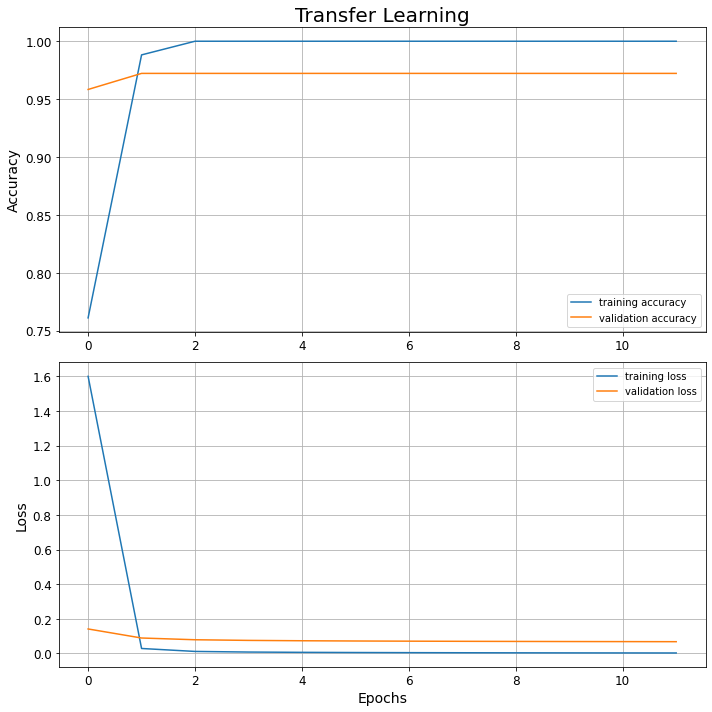

In [8]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transfer Learning', fontsize=20)
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
plt.grid(True)
plt.savefig('../08_Images/mobilenet_transfer_learning')
plt.show()

# FINE TUNING
col mio computer è possibile solo per mobilenet

In [9]:
base_model.trainable=True
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                               

In [10]:
es = [EarlyStopping(monitor='val_accuracy',
                              patience=patience,
                              min_delta=min_delta,
                              mode=mode),
                 ModelCheckpoint(filepath=r"C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\mobilenet", monitor='val_accuracy', save_best_only=True)]

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss=loss,
              metrics=metrics)

history = model.fit(x=train_ds,
                    validation_data=valid_ds,
                    epochs=epochs,
                    verbose=verbose,
                    callbacks=es)

Epoch 1/30
INFO:tensorflow:Assets written to: C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\mobilenet\assets
11/11 - 16s - loss: 0.1708 - accuracy: 0.9145 - val_loss: 0.8752 - val_accuracy: 0.8056 - 16s/epoch - 1s/step
Epoch 2/30
INFO:tensorflow:Assets written to: C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\mobilenet\assets
11/11 - 13s - loss: 0.0407 - accuracy: 0.9823 - val_loss: 0.4379 - val_accuracy: 0.9306 - 13s/epoch - 1s/step
Epoch 3/30
11/11 - 5s - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.5087 - val_accuracy: 0.9306 - 5s/epoch - 431ms/step
Epoch 4/30
INFO:tensorflow:Assets written to: C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\mobilenet\assets
11/11 - 12s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3297 - val_accuracy: 0.9583 - 12s/epoch - 1s/step
Epoch 5/30
INFO:tensorflow:Assets written to: C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\mobilenet\assets
11/11 - 13s - lo

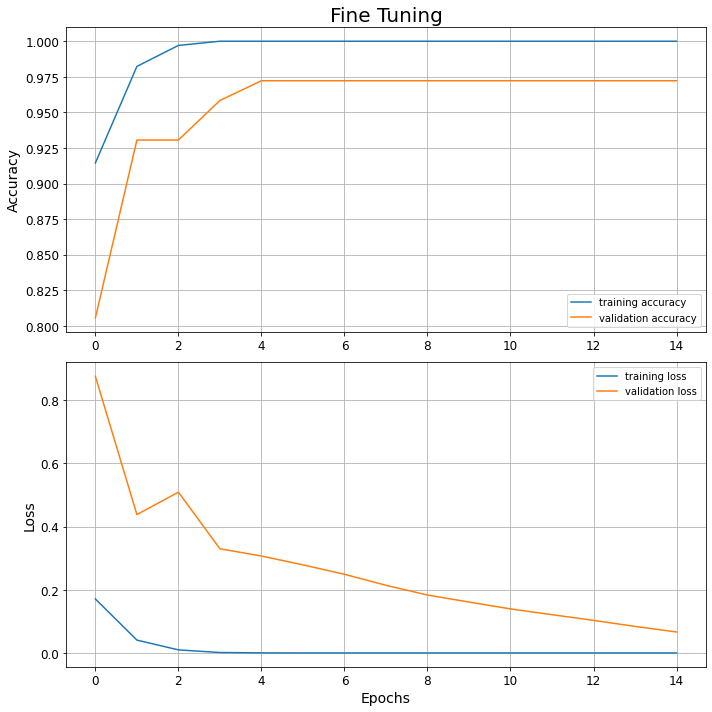

In [11]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fine Tuning', fontsize=20)
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
plt.grid(True)
plt.savefig('../08_Images/mobilenet_fine_tuning')
plt.show()

# Make Predictions

In [12]:
'''import the trained model and the test's dataset'''
trained_model = keras.models.load_model(r"C:\Users\Pietro\OneDrive - Politecnico di Milano\Desktop\Tesi\modelli\mobilenet")
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',#'int' for sparse_categorical_cross_entropy
    label_mode='categorical',
    class_names=['BAD', 'GOOD'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size,img_size),
    shuffle=False,
    seed=123,
)

Found 75 files belonging to 2 classes.


In [13]:
import time
start1=time.time()
predictions = trained_model.predict(x=test_ds, steps=len(test_ds), verbose=0)
end1=time.time()
time_list1=end1-start1
print(time_list1)
print(str(time_list1/75) + ' [s] for each image')

2.075610399246216
0.027674805323282876 [s] for each image


In [14]:
arr_1d=np.argmax(predictions,axis=1)
print(arr_1d)
np.count_nonzero(arr_1d)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


40

In [15]:
trained_model.evaluate(test_ds)

3/3 [==============================] - 2s 205ms/step - loss: 0.0145 - accuracy: 1.0000


[0.014457538723945618, 1.0]

tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1], shape=(75,), dtype=int64)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1], shape=(75,), dtype=int64)
75
Confusion matrix, without normalization
[[35  0]
 [ 0 40]]


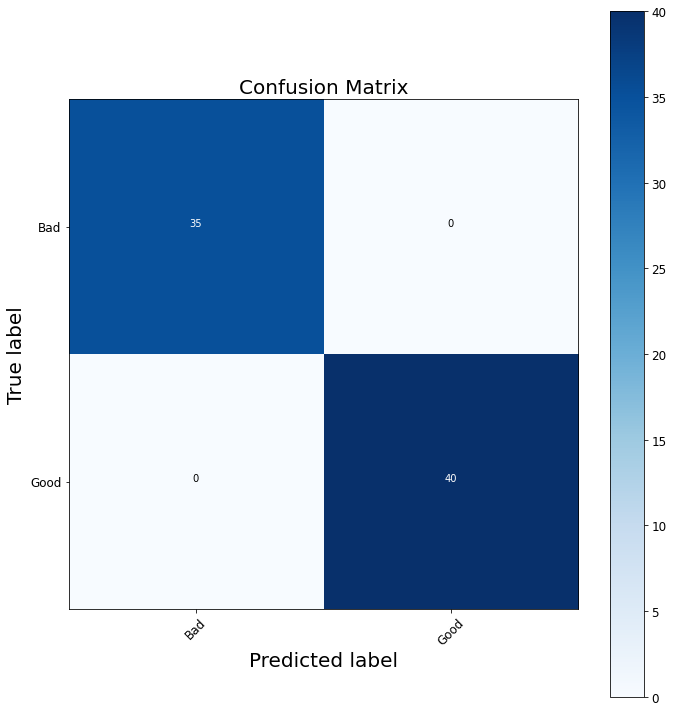

In [16]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))

y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

print(y_pred)
print(y_true)
print(len(y_true))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['Bad', 'Good']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.tight_layout()
plt.savefig('../08_Images/Confusion_Matrix_mobilenet')